# Метод случайного леса
Всем ку, сегодня мы изучим еще один небольшой алгоритм машинного обучения, который называется Метод случайного леса. 
Как всегда, перед тем как применить его, нам нужно в очередной раз обработать информацию, и представить ее в более понятном и удобном виде

## Датасет

наш датасет представляет собой информацию о ценах продажи домов в округе штата Вашингтона, Кинг Каунти. Давайте посмотрим на этот датасет поближе

In [11]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

In [12]:
db=pd.read_csv('kc_house_data.csv')
db.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [13]:
#Найдем missing дату
print(db.isnull().any())
print(db.dtypes)

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_

## УРА!
Пропущенных значений тут нет, и все столбцы сразу же имеют числовой формат (кроме столбца даты, но это легко меняется). Давайте вообще уберем отсюда дату и числовой идентификатор, они нам не нужны тут вообще.

In [14]:
db.drop(labels=['date','id'], axis=1, inplace=True)

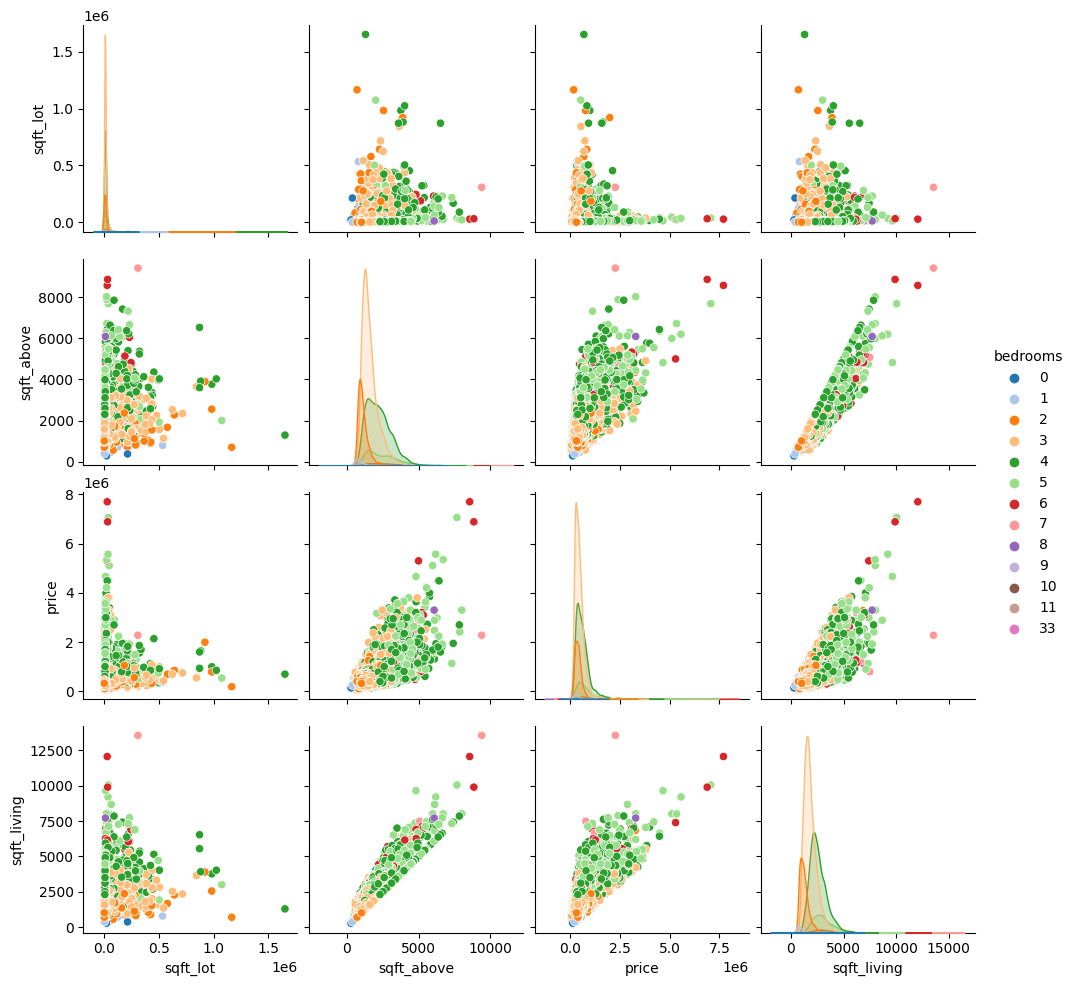

In [15]:
#Теперь визуализируем данные попарно, например.
sns.pairplot(db[['sqft_lot','sqft_above','price','sqft_living','bedrooms']], hue='bedrooms', palette='tab20')

Как видно, есть прям очевидные линейные зависимости некоторых параметров. 

Столбец price имеет вид <class 'numpy.float64'>. Пример: 538000.0
Столбец bedrooms имеет вид <class 'numpy.int64'>. Пример: 3
Столбец bathrooms имеет вид <class 'numpy.float64'>. Пример: 2.25
Столбец sqft_living имеет вид <class 'numpy.int64'>. Пример: 2570
Столбец sqft_lot имеет вид <class 'numpy.int64'>. Пример: 7242
Столбец floors имеет вид <class 'numpy.float64'>. Пример: 2.0
Столбец waterfront имеет вид <class 'numpy.int64'>. Пример: 0
Столбец view имеет вид <class 'numpy.int64'>. Пример: 0
Столбец condition имеет вид <class 'numpy.int64'>. Пример: 3
Столбец grade имеет вид <class 'numpy.int64'>. Пример: 7
Столбец sqft_above имеет вид <class 'numpy.int64'>. Пример: 2170
Столбец sqft_basement имеет вид <class 'numpy.int64'>. Пример: 400
Столбец yr_built имеет вид <class 'numpy.int64'>. Пример: 1951
Столбец yr_renovated имеет вид <class 'numpy.int64'>. Пример: 1991
Столбец zipcode имеет вид <class 'numpy.int64'>. Пример: 98125
Столбец lat имеет вид <class 'numpy.float64'>. Пример: 4

<AxesSubplot: title={'center': 'Корреляция признаков по Пирсону'}>

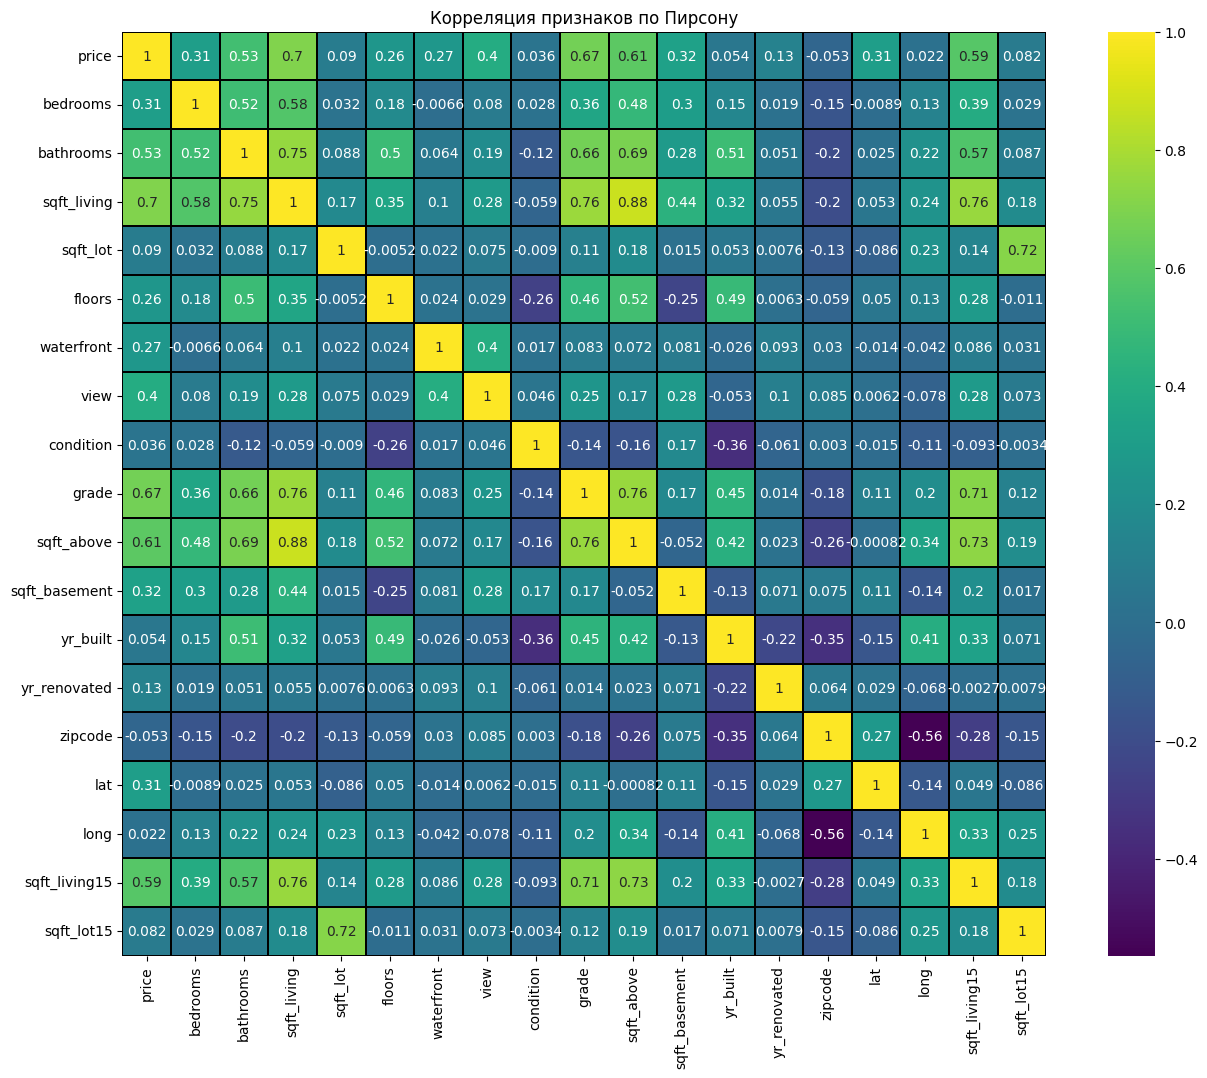

In [16]:
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in db.items():
    print(f"Столбец {colname} имеет вид {type(colvalue[1])}. Пример: {colvalue[1]}")
#Как видно, все имеют числовой формат, но некоторые int, а некоторые float. To build a heatmap, we should make all columns into float
f, ax = plt.subplots(figsize=(16, 12))
plt.title('Корреляция признаков по Пирсону')
sns.heatmap(db.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="viridis", linecolor='k', annot=True )

Какие можно сделать выводы, просто смотря на эту тепловую карту?

Можно сразу сказать, что существует зависимость, к примеру, между:
* Кол-вом этажей и кол-вом ванных комнат (floar and bathrooms)
* 


Также пока это писал, узнал что на хабре есть какая-то небольшая инфа по этому же датасету, вот ссылка
https://habr.com/ru/post/505516/

In [17]:
Y=db.price.values
X=db
X.drop(['price'],axis=1,inplace=True)
X=X.values
colnames=db.columns
print(X)

[[ 3.00000e+00  1.00000e+00  1.18000e+03 ... -1.22257e+02  1.34000e+03
   5.65000e+03]
 [ 3.00000e+00  2.25000e+00  2.57000e+03 ... -1.22319e+02  1.69000e+03
   7.63900e+03]
 [ 2.00000e+00  1.00000e+00  7.70000e+02 ... -1.22233e+02  2.72000e+03
   8.06200e+03]
 ...
 [ 2.00000e+00  7.50000e-01  1.02000e+03 ... -1.22299e+02  1.02000e+03
   2.00700e+03]
 [ 3.00000e+00  2.50000e+00  1.60000e+03 ... -1.22069e+02  1.41000e+03
   1.28700e+03]
 [ 2.00000e+00  7.50000e-01  1.02000e+03 ... -1.22299e+02  1.02000e+03
   1.35700e+03]]


Далее мы будем использовать для оценки несколько методов для тренировки машинного обучения. Для этого мы воспользуемся также словарем ranging, со своей функцией, которая будет подсчитывать рейтинг различных методов.
Метод был придуман изначально Nicolai Meinshausen и Peter Buhlmann в работе http://stat.ethz.ch/~nicolai/stability.pdf. Если хотите, можете прочитать на досуге вечером, но понимать вы будете пару недель 
то всё.

In [18]:
ranks={}
def ranking(ranks,names,order=1):
    minmax=MinMaxScaler()
    ranks=minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks=map(lambda x:round(x,2),ranks)
    return dict(zip(names,ranks))

Стоит отметить, что мы сейчас будем делать. Существует метод по ранжированию объектов. Recursive Feature Elimination, Рекурсивное исключение объекта, или же просто RFE метод, находит в модели регрессии (в примере ниже - в линейной регрессии) наилучший или наихудший признак, и исключает его. Затем он повторят этот процесс до тех пор, пока не будут использованы все объекты в наборе данных (ну или до определенного пользователем предела, я здесь его не указывал, поэтому он пройдется по всем) 

In [20]:
lr = LinearRegression()
lr.fit(X,Y)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose =3 )
rfe.fit(X,Y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


In [46]:
print(f"Выпишем последовательность номеров признаков, которые больше всего влияют на поведение линейной регрессии.\n{rfe.ranking_}")

Выпишем последовательность номеров признаков, которые больше всего влияют на поведение линейной регрессии.
[10 11  1 18 13  4  8  9  7  2  3 12 16 14  5  6 15 17]


Теперь давайте применим 3 различные линейные модели (линейную регрессию, регрессию лассо и регрессию гребня) и рассмотрим, как объекты выбираются и расставляются приоритеты с помощью этих моделей. Чтобы достичь этого, я буду использовать реализацию sklearn этих моделей и, в частности, атрибут .coef для возврата оценочных коэффициентов для каждого объекта в линейной модели.

In [43]:
# Using Linear Regression
lr = LinearRegression()
lr.fit(X,Y)
ranks["LinReg"] = ranking(np.abs(lr.coef_), colnames)

# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(X,Y)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)

c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.982e+14, tolerance: 2.913e+11
  model = cd_fast.enet_coordinate_descent(


Модель случайного леса Sklearn также поставляется со своим собственным встроенным атрибутом ранжирования объектов, и ее удобно вызывать через "featureimportances". Это то, что мы будем использовать следующим образом:

In [32]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
''' 
n_estimators — число деревьев в "лесу" (по дефолту – 10)
    criterion — функция, которая измеряет качество разбиения ветки дерева (по дефолту — "mse" , так же можно выбрать "mae")
    max_features — число признаков, по которым ищется разбиение. Вы можете указать конкретное число или процент признаков, либо выбрать из доступных значений: "auto" (все признаки), "sqrt", "log2". По дефолту стоит "auto".
    max_depth — максимальная глубина дерева  (по дефолту глубина не ограничена)
    min_samples_split — минимальное количество объектов, необходимое для разделения внутреннего узла. Можно задать числом или процентом от общего числа объектов (по дефолту — 2)
    min_samples_leaf — минимальное число объектов в листе. Можно задать числом или процентом от общего числа объектов (по дефолту — 1)
    min_weight_fraction_leaf — минимальная взвешенная доля от общей суммы весов (всех входных объектов) должна быть в листе (по дефолту имеют одинаковый вес)
    max_leaf_nodes — максимальное количество листьев (по дефолту нет ограничения)
    min_impurity_split — порог для остановки наращивания дерева (по дефолту 1е-7)
    bootstrap — применять ли бустрэп для построения дерева (по дефолту True)
    oob_score — использовать ли out-of-bag объекты для оценки R^2 (по дефолту False)
    n_jobs — количество ядер для построения модели и предсказаний (по дефолту 1, если поставить -1, то будут использоваться все ядра)
    random_state — начальное значение для генерации случайных чисел (по дефолту его нет, если хотите воспроизводимые результаты, то нужно указать любое число типа int
    verbose — вывод логов по построению деревьев (по дефолту 0)
    warm_start — использует уже натренированую модель и добавляет деревьев в ансамбль (по дефолту False)
'''
rf.fit(X,Y)
ranks["RF"] = ranking(rf.feature_importances_, colnames);

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.0s


building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.2s finished


In [33]:
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

	Lasso	LinReg	RF	RFE	Ridge	Mean
bedrooms	0.06	0.06	0.0	0.47	0.06	0.13
bathrooms	0.07	0.07	0.02	0.41	0.07	0.13
sqft_living	0.0	0.0	0.82	1.0	0.0	0.36
sqft_lot	0.0	0.0	0.04	0.0	0.0	0.01
floors	0.01	0.01	0.0	0.29	0.01	0.06
waterfront	0.97	0.97	0.09	0.82	0.94	0.76
view	0.09	0.09	0.03	0.59	0.09	0.18
condition	0.04	0.04	0.0	0.53	0.04	0.13
grade	0.16	0.16	1.0	0.65	0.16	0.43
sqft_above	0.0	0.0	0.07	0.94	0.0	0.2
sqft_basement	0.0	0.0	0.01	0.88	0.0	0.18
yr_built	0.0	0.0	0.07	0.35	0.0	0.08
yr_renovated	0.0	0.0	0.0	0.12	0.0	0.02
zipcode	0.0	0.0	0.04	0.24	0.0	0.06
lat	1.0	1.0	0.51	0.76	1.0	0.85
long	0.36	0.36	0.21	0.71	0.35	0.4
sqft_living15	0.0	0.0	0.09	0.18	0.0	0.05
sqft_lot15	0.0	0.0	0.04	0.06	0.0	0.02


In [34]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

<AxesSubplot: xlabel='Mean Ranking', ylabel='Feature'>

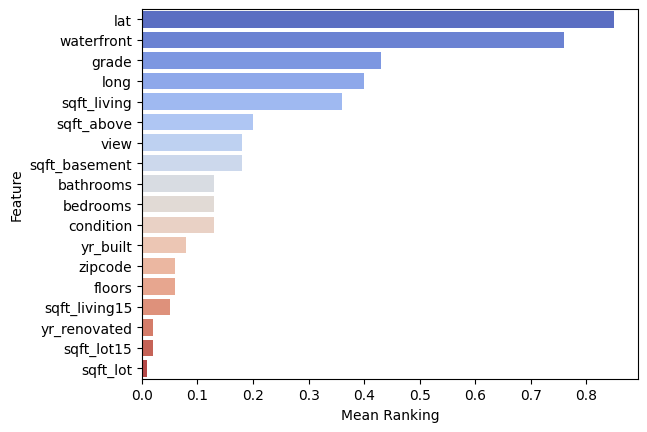

In [39]:
# Let's plot the ranking of the features
sns.barplot(x="Mean Ranking", y="Feature", data = meanplot, 
             palette='coolwarm')

Как видно, используя написанную ранее функцию ranking, она через minmaxscaling преобразовала результаты влияния величин на цену дома. Потом мы взяли среднюю величину от нескольких методов, таким образом получил среднее число, более достоверное чем каждый их этих методов по отдельности. Также такой метод позволяет нам полностью избежать переобучения, потому что у нас несколько пакетов на которых строится среднее.